In [73]:
''' This file depends on intermediate results produced by 06_process_metrics.py.
'''

%pylab inline
from core import db,abm
import pandas
import shelve
import gzip
import pickle
from sklearn.linear_model import LinearRegression

reload(db),reload(abm)

scenarios = ['k5', 'k6', 'k7', 'k5-idp', 'k6-idp', 'k7-idp']
allocation = ['Nearest', 'Nearest', 'Nearest', 'Inverse distance', 'Inverse distance', 'Inverse distance']

scenario_name = dict(zip(scenarios, allocation))

sim = 'bristol25'

Populating the interactive namespace from numpy and matplotlib


In [69]:
scenarios

['k5', 'k6', 'k7', 'k5-idp', 'k6-idp', 'k7-idp']

# First, produce the fundamental diagram

In [2]:
fd = abm.FundamentalDiagram(speedup=1,k_lim=7,k_vmin=5.0)

/home/bk12369/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


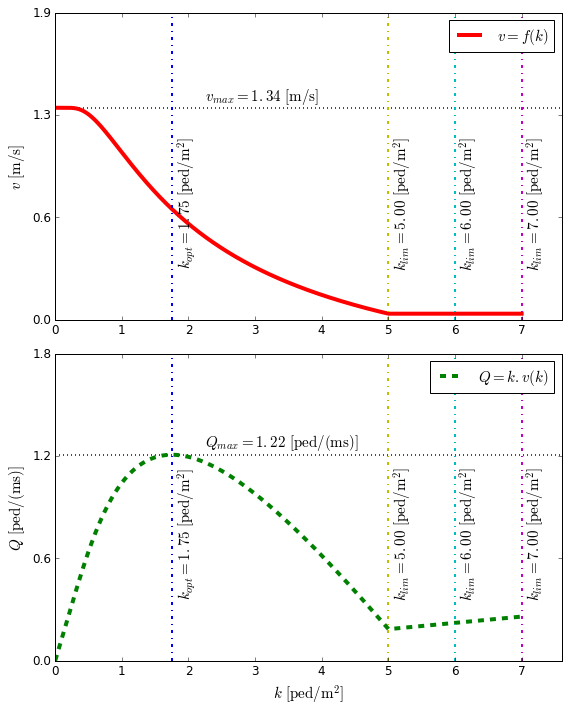

In [3]:
def figure_metrics(self):
    x_offset = 0.6
    y_offset = 0.6
    k = self.k
    self.fontsize=15
    self.ticksize=12
    v = [v/self.speedup for v in self.v]
    q = [q/self.speedup for q in self.q]
    fig, (ax1,ax2) = plt.subplots(2, sharex=False, figsize=(8,10))
    fig.set_tight_layout(True)
    ax1.plot(k,v,'r-',linewidth=4,label='$v=f(k)$')
    ax1.set_xlim(0,self.k_max+x_offset)
    ax1.set_ylabel(self.velocityLabel,fontsize=self.fontsize)
    ax1.set_ylim(0,self.v_ff+y_offset)
    ax1.tick_params(axis='both', labelsize=self.ticksize)
    ax1.yaxis.set_major_locator(LinearLocator(4))
    ax1.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

    #ax.legend(loc=2,fontsize=self.fontsize)
    ax2.plot(k,q,'g--',linewidth=4,label='$Q = k.v(k)$')
    ax2.set_xlim(0,self.k_max+x_offset)
    ax2.set_xlabel(self.densityLabel,fontsize=self.fontsize)
    ax2.set_ylabel(self.flowLabel,fontsize=self.fontsize)
    ax2.set_ylim(min(q),max(q)+y_offset)
    ax2.tick_params(axis='both', labelsize=self.ticksize)        
    ax2.yaxis.set_major_locator(LinearLocator(4))
    ax2.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))        

    ax1.axhline(max(v),c='r',linestyle=':',linewidth=2)
    ax1.text(self.k_opt+0.5,max(v)+0.05,'$v_{{max}} = {:0.2f} \ \mathrm{{ [m/s] }}$'.format(max(v)),fontsize=self.fontsize)
    ax2.axhline(max(q),c='g',linestyle=':',linewidth=2)
    ax2.text(self.k_opt+0.5,max(q)+0.05,'$Q_{{max}} = {:0.2f} \ \mathrm{{ [ped/(ms)] }}$'.format(max(q)),fontsize=self.fontsize)
    for i,ax in enumerate([ax1,ax2]):
        ax.axvline(self.k_opt,c='b',linestyle='-.',linewidth=2)
        ax.text(self.k_opt+0.05,1.06,'$k_{{opt}} = {:0.2f} \ \mathrm{{ [ped/m^2 ] }}$'.format(self.k_opt),fontsize=self.fontsize,rotation=90)

    fname = 'pre2015/fd-revision.pdf'        
    for k_lim,c in zip([5,6,7],['y','c','m']):
        for ax in [ax1, ax2]:
            ax.axvline(k_lim,c=c,linestyle='-.',linewidth=2)
            ax.text(k_lim+0.05,1.06,'$k_{{lim}} = {:0.2f} \ \mathrm{{ [ped/m^2] }}$'.format(k_lim),fontsize=self.fontsize,rotation=90)

    ax1.legend(loc=1,fontsize=self.fontsize)
    ax2.legend(loc=1,fontsize=self.fontsize)            
    fig.savefig(fname,bbox_inches='tight')
    return fig

fig = figure_metrics(fd)

# Process all the necessary data

In [4]:
# ---------------------------------------------------------
# Pretty label
pl = {
    'N':'N',
    'W':'W',
    'Dmax':'D^{max}',
    'Ds':'D^{\sigma}',
    'Dm':'\overline{D}',
    'D50':'D^{50\%}',
    'D90':'D^{90\%}',
    'Tmax':'T^{max}',
    'Tmaxf':'T^{max}_f',
    'Ts':'T^{\sigma}',
    'Tm':'\overline{T}',
    'T90':'T^{90\%}',
    'T90f':'T^{90\%}_f',
    'T90f1i':'T^{90\%}_{f1}',
    'T90f2i':'T^{90\%}_{f2}',
    'T90b':'T^{90\%}_b',
    'Qmax':'Q^{max}',
    'Qs':'Q^{\sigma}',
    'Qm':'\overline{Q}',
    'Qmf':'\overline{Q}_f',
    'Qmf1':'\overline{Q}_{f1}',
    'Qmf2':'\overline{Q}_{f2}',
    'Qmb':'\overline{Q}_b',
    'Q50':'Q^{50\%}',
    'Q50f':'Q^{50\%}_f',
    'Q50f1':'Q^{50\%}_{f1}',
    'Q50f2':'Q^{50\%}_{f2}',
    'Q50b':'Q^{50\%}_b',
    'Q90':'Q^{90\%}',
    'Q90f':'Q^{90\%}_f',
    'Q90f1':'Q^{90\%}_{f1}',
    'Q90f2':'Q^{90\%}_{f2}',
    'Q90b':'Q^{90\%}_b',
    'Qp':'Q_c',     
     }

unit = {
    'N':'[ped]',
    'W':'[m]',
    'Dmax':'[m]',
    'Ds':'[m]',
    'Dm':'[m]',
    'D50':'[m]',
    'D90':'[m]',
    'Tmax':'[s]',
    'Tmaxf':'[s]',
    'Ts':'[s]',
    'Tm':'[s]',
    'T90':'[s]',
    'T90f':'[s]',
    'T90f1i':'[s]',
    'T90f2i':'[s]',
    'T90b':'[s]',
    'Qmax':'[ped/(ms)]',
    'Qs':'[ped/(ms)]',
    'Qm':'[ped/(ms)]',
    'Qmf':'[ped/(ms)]',
    'Qmf1':'[ped/(ms)]',
    'Qmf2':'[ped/(ms)]',
    'Qmb':'[ped/(ms)]',
    'Q50':'[ped/(ms)]',
    'Q50f':'[ped/(ms)]',
    'Q50f1':'[ped/(ms)]',
    'Q50f2':'[ped/(ms)]',
    'Q50b':'[ped/(ms)]',
    'Q90':'[ped/(ms)]',
    'Q90f':'[ped/(ms)]',
    'Q90f1':'[ped/(ms)]',
    'Q90f2':'[ped/(ms)]',
    'Q90b':'[ped/(ms)]',
    'Qp':'[ped/(ms)]',
     }


places = sorted(abm.Places(sim).names)

pop = {}
for place in places:
    # Load poopulation
    pop[place] = db.Population(place,table='pop_gpwv4_2015')
total_pop = [sum(pop[place].pop) for place in places]
sorted_places,sorted_pop = zip(*sorted(zip(places,total_pop),key=lambda tot: tot[1],reverse=True))

W_dict = {}
for place in places:
    W_dict[place] = pandas.DataFrame([(k,sum(v.values())) for k,v in shelve.open('metadata/bristol25/{}/common.shelve'.format(place))['destin_width'].iteritems()],columns=['destin','W']).set_index('destin')
W = pandas.concat(W_dict)['W']

DF = {}
for scenario in scenarios:
    DF_dict = {}
    print 'loading', scenario
    for place in places:
        hdf = pandas.HDFStore('metadata/bristol25/{}/agents.hdf'.format(place)) 
        df = hdf.get(scenario)
        hdf.close()
        DF_dict[place] = df 
    DF[scenario] = pandas.concat(DF_dict)

for scenario in scenarios:  
    DF[scenario].set_index('destin',append=True,inplace=True)

scenario = 'k5'

SDF = {}
Q = {}
N = {}
T90 = {}
D90 = {}
T90f = {}
Qmf = {}
Qp = {}
Qr = {}
Tr = {}
Qf = {}
for scenario in scenarios:
    print 'loading', scenario
    grouped = DF[scenario].groupby(level=[0,2])
    T90[scenario] = grouped['time2x'].quantile(0.9)
    D90[scenario] = grouped['dist2x'].quantile(0.9)
    T90f[scenario] = D90[scenario]/60/1.34
    N[scenario] = grouped['dist2x'].count()
    Q[scenario] = grouped['time2x'].agg(lambda v: tuple(np.histogram(v,bins=range(int(max(v)+2)))[0]))
    Qmf[scenario] = Q[scenario].copy(deep=True)
    Qp[scenario] = Q[scenario].copy(deep=True)
    Qmf[scenario][:] = None
    Qp[scenario][:] = None

    for place,destin in Q[scenario].index:
        Qmf[scenario].loc[place,destin] = np.mean(np.array(Q[scenario].loc[place,destin])[:int(T90f[scenario].loc[place,destin])+1])/W.loc[place,destin]/60
        Qp[scenario].loc[place,destin] = N[scenario].loc[place,destin]/T90f[scenario].loc[place,destin]/W.loc[place,destin]/60
    Tr[scenario] = T90[scenario]/T90f[scenario]
    Qr[scenario] = Qmf[scenario]/Qp[scenario]

for scenario in scenarios:
    print 'loading', scenario
    df = DF[scenario]['dist2x'].apply(lambda x: x/60/1.34)
    grouped = df.groupby(level=[0,2])
    Qf[scenario] = grouped.agg(lambda v: tuple(np.histogram(v,bins=range(int(max(v)+1)))[0]))

def gini(list_of_values):
    sorted_list = sorted(list_of_values)
    height, area = 0, 0
    for value in sorted_list:
        height += value
        area += height - value / 2.
    fair_area = height * len(list_of_values) / 2.
    return (fair_area - area) / fair_area

cityDF = {}

for scenario in ['k5','k5-idp']:
    cityDF[scenario] = pandas.DataFrame({
                'T90f': DF[scenario]['dist2x'].groupby(level=0).quantile(q=0.9)/1.34/60,
                'T90': DF[scenario]['time2x'].groupby(level=0).quantile(q=0.9),
            })

    
    cityDF[scenario]['T90/T90f'] = (cityDF[scenario]['T90']/cityDF[scenario]['T90f'])
    cityDF[scenario]['rank'] = cityDF[scenario]['T90/T90f'].rank(ascending=False)
    cityDF[scenario]['gini'] = N[scenario].groupby(level=0).apply(gini).round(2).loc[list(sorted_places)]
    cityDF[scenario]['T90/T90f'] = cityDF[scenario]['T90/T90f'].round(2)
    cityDF[scenario]['T90'] = cityDF[scenario]['T90'].round()
    cityDF[scenario]['T90f'] = cityDF[scenario]['T90f'].round()

cDF = pandas.concat(cityDF)[['T90','T90f','T90/T90f','rank','gini']].unstack(level=0).T.swaplevel(1,0).sort_index(level=0).T.loc[list(sorted_places)]
cDF['rank'] = range(1,51)
cDF=cDF.set_index('rank',append=True).swaplevel()
cDF.to_latex('pre2015/cityDF.tex')

norm_pl = '{}/{}'.format(pl['T90'],pl['T90f'])

Loading places/bristol25
Aberdeen City: Loading db/gis/Aberdeen City/pop_gpwv4_2015
Amber Valley: Loading db/gis/Amber Valley/pop_gpwv4_2015
Arun: Loading db/gis/Arun/pop_gpwv4_2015
Birmingham: Loading db/gis/Birmingham/pop_gpwv4_2015
Bridgend: Loading db/gis/Bridgend/pop_gpwv4_2015
Bromsgrove: Loading db/gis/Bromsgrove/pop_gpwv4_2015
Caerphilly: Loading db/gis/Caerphilly/pop_gpwv4_2015
Charnwood: Loading db/gis/Charnwood/pop_gpwv4_2015
Chiltern: Loading db/gis/Chiltern/pop_gpwv4_2015
Chorley: Loading db/gis/Chorley/pop_gpwv4_2015
City of Bristol: Loading db/gis/City of Bristol/pop_gpwv4_2015
City of Edinburgh: Loading db/gis/City of Edinburgh/pop_gpwv4_2015
Dacorum: Loading db/gis/Dacorum/pop_gpwv4_2015
Darlington: Loading db/gis/Darlington/pop_gpwv4_2015
Fylde: Loading db/gis/Fylde/pop_gpwv4_2015
Great Yarmouth: Loading db/gis/Great Yarmouth/pop_gpwv4_2015
Guildford: Loading db/gis/Guildford/pop_gpwv4_2015
Hart: Loading db/gis/Hart/pop_gpwv4_2015
Kettering: Loading db/gis/Kettering/p

# City ETE histogram

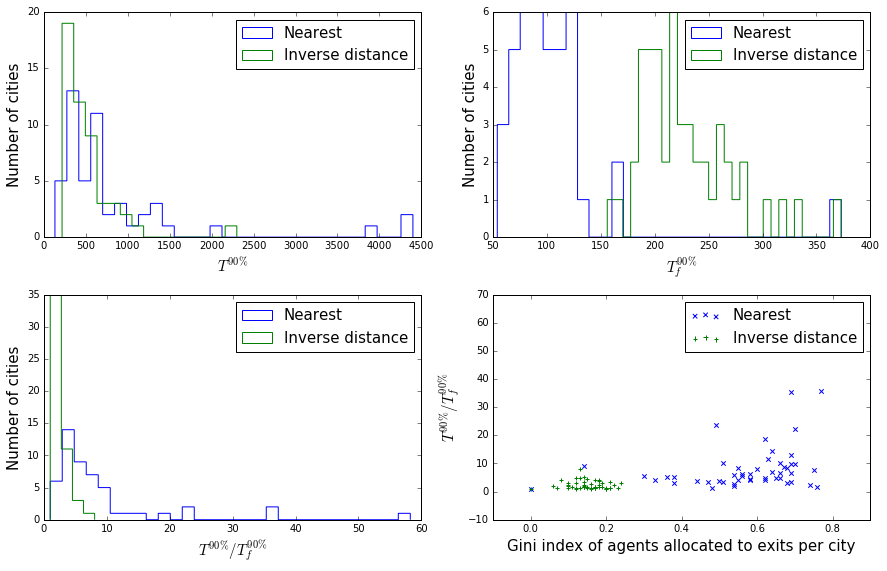

In [8]:
plt.figure(figsize=(12.5,8))
i = 0
for label,pretty_label in zip(['T90','T90f','T90/T90f'],[pl['T90'],pl['T90f'],norm_pl]):
    plt.subplot(221+i)
    i += 1
    max_val = max(cDF[('k5',label)].max(),cDF[('k5-idp',label)].max())
    for scenario in ['k5','k5-idp']:
        # Number of bins is proportional to the largest value
        plt.hist(cDF[(scenario,label)],bins=int(30*cDF[(scenario,label)].max()/max_val),label=scenario_name[scenario],histtype='step',cumulative=False)
        plt.xlabel('${}$'.format(pretty_label),fontsize=15)
        plt.ylabel('Number of cities',fontsize=15)
        plt.legend(loc='upper right',fontsize=15)

                
# Gini index
plt.subplot(221+i)
for scenario,color,marker in zip(['k5','k5-idp'],['blue','green'],['x','+']):
    plt.scatter(cDF[(scenario,'gini')],cDF[(scenario,'T90/T90f')],label=scenario_name[scenario],marker=marker,c=color)
plt.xlabel('Gini index of agents allocated to exits per city',fontsize=15)    
plt.ylabel('${}$'.format(norm_pl),fontsize=15)
plt.legend(loc='upper right',fontsize=15)
plt.tight_layout()
plt.savefig('pre2015/cityETEhist.pdf',bbox_inches='tight')

# Load City of Bristol

In [168]:
from scipy import stats
print stats.pearsonr(cDF['k5','T90/T90f'],sorted_pop)
print stats.pearsonr(cDF['k5-idp','T90/T90f'],sorted_pop)

print stats.spearmanr(cDF['k5','T90/T90f'],sorted_pop)
print stats.spearmanr(cDF['k5-idp','T90/T90f'],sorted_pop)

import networkx as nx
s = abm.Sim('bristol25','City of Bristol')
s.h.init_route()
pos = nx.get_node_attributes(s.h.G,'pos')

destins = s.h.destins

colors =   ["#0070ad",
            "#ffcf0a",
            "#dc54ff",
            "#679200",
            "#fb00b6",
            "#01fde7",
            "#ff075e",
            "#018862",
            "#9574ff",
            "#ff6322",
            "#001919",
            "#ffd3bc",
            "#2f1000",
            "#d0d5ff",
            "#983600",
            "#6a002e",
            "#8d0020"]

destin_color = dict(zip(destins,colors))

sample = [48154, 21817, 9957]

attr = dict(zip(sample, [{'label':'CA01','zorder':2},
                            {'label':'CA02','zorder':1},
                            {'label':'CA03','zorder':3},

                        ]))

(0.31516962703241269, 0.025789044398647543)
(0.42702495018343489, 0.0019832456783453129)
SpearmanrResult(correlation=0.49484981646475829, pvalue=0.00025903995374077849)
SpearmanrResult(correlation=0.53431302172211037, pvalue=6.4247898082438328e-05)
City of Bristol: Loading db/gis/City of Bristol/boundary
City of Bristol: Loading db/gis/City of Bristol/pop_gpwv4_2015
City of Bristol: Loading db/gis/City of Bristol/highway.lite.gpickle
City of Bristol: Loading db/gis/City of Bristol/highway.class
City of Bristol: Loading db/gis/City of Bristol/highway.destins
City of Bristol: There are 17 unique destination(s).
City of Bristol: Loading db/gis/City of Bristol/highway.lite.route/10306
City of Bristol: Loading db/gis/City of Bristol/highway.lite.route/9957
City of Bristol: Loading db/gis/City of Bristol/highway.lite.route/49969
City of Bristol: Loading db/gis/City of Bristol/highway.lite.route/17032
City of Bristol: Loading db/gis/City of Bristol/highway.lite.route/9895
City of Bristol: Loa

# FIG 2A showing City of Bristol catchment areas

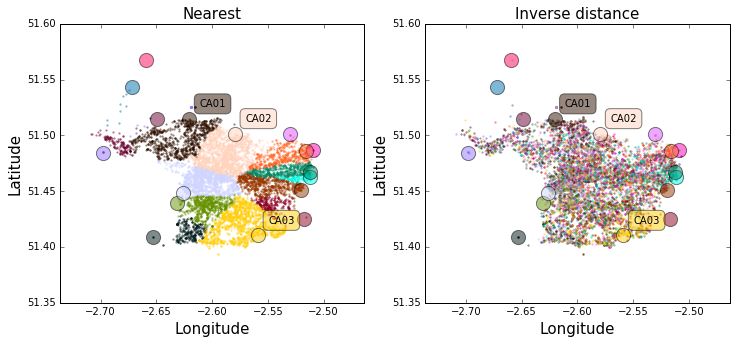

In [10]:
# Catchment areas
plt.close('all')
plt.figure(figsize=(12,5))
for i,scenario in enumerate(['k5','k5-idp']):

    ie = DF[scenario].loc['City of Bristol']['initedge']

    agents_to_show = list(np.random.choice(range(len(ie)),len(ie)/50))

    # plt.figure()
    # for x,edge in ie.loc[agents_to_show].values:
    #     nxedges = nx.draw_networkx_edges(h.G,pos=pos,arrows=False,edgelist=[edge],edge_color=destin_color[x],width=1,alpha=0.1)

    plt.subplot(121+i)
    for k,v in ie.loc[agents_to_show].iteritems():
        _,x = k
        u,_ = v
        plt.scatter(*pos[u],c=destin_color[x],marker='.',alpha=0.5,linewidth=0)
        # nxedges = nx.draw_networkx_edges(h.G,pos=pos,arrows=False,edgelist=[edge],edge_color=destin_color[x],width=1,alpha=0.1)

    for x in destins:
        plt.scatter(*pos[x],s=200,c=destin_color[x],alpha=0.5,marker='o')

    for x,v in attr.iteritems():
        plt.annotate(
            v['label'],
            xy = pos[x], xytext = (10,10),
            textcoords = 'offset points', ha = 'left', va = 'bottom',
            bbox = dict(boxstyle = 'round,pad=0.5', fc = destin_color[x], alpha = 0.5))
        
    plt.title(scenario_name[scenario],fontsize=15)
    plt.xlabel('Longitude',fontsize=15)
    plt.ylabel('Latitude',fontsize=15)
    plt.axis('equal')

plt.savefig('pre2015/Bristol-CA.pdf',bbox_inches='tight')  

# FIG 2B showing how agents are distributed across example catchment areas

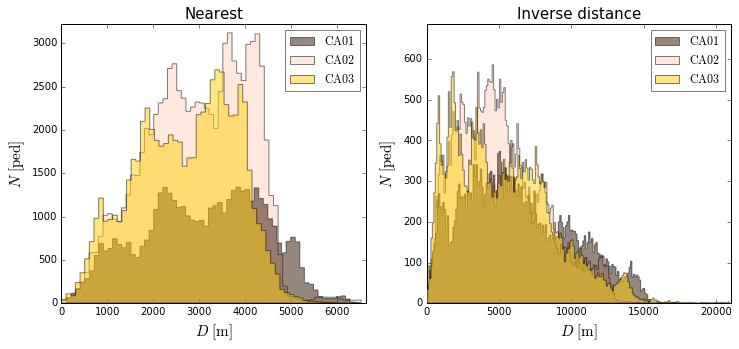

In [11]:
# Number of agents for a sample of catchement areas in Bristol

plt.figure(figsize=(12,5))
for i,scenario in enumerate(['k5','k5-idp']):
    dx = DF[scenario]['dist2x'].loc['City of Bristol'].groupby(level=1).agg(lambda x: tuple(x))

    xlim = 0
    ylim = 0

    plt.subplot(121+i)

    import matplotlib.pyplot as plt
    for x in sample:
        try:
            data = dx.loc[x]
            h,b,p = plt.hist(dx.loc[x],bins=int(np.max(data)/100),alpha=0.5,label='$\mathrm{{ {0} }}$'.format(attr[x]['label']),facecolor=destin_color[x], histtype='stepfilled',zorder=attr[x]['zorder'])
            ylim = max(ylim,h.max())
            xlim = max(xlim,b.max())
        except KeyError:
            pass
        
    plt.xlim(0,xlim+100);plt.ylim(0,ylim+100)

    plt.title(scenario_name[scenario],fontsize=15)
    plt.xlabel('$D \ \mathrm{[m]}$',fontsize=15)
    plt.ylabel('$N \ \mathrm{[ped]}$',fontsize=15)
    plt.legend(framealpha=0.5)
    #plt.grid()

plt.savefig('pre2015/Bristol-DvN.pdf',bbox_inches='tight')  

# FIG 3A: Distrubution of number of CAs across cities

k5
std 5.93533177382
mean 12.58
sum 629
k5-idp
std 7.40570656966
mean 15.18
sum 759


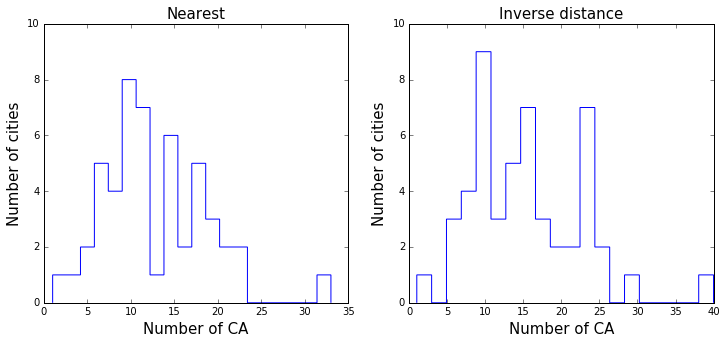

In [12]:
plt.figure(figsize=(12,5))
for i,scenario in enumerate(['k5','k5-idp']):
    CA_per_city = N[scenario].groupby(level=0).count()
    print scenario
    print 'std',CA_per_city.std()
    print 'mean',CA_per_city.mean()
    print 'sum',CA_per_city.sum()

    plt.subplot(121+i)    
    plt.hist(CA_per_city,bins=20,histtype='step')
    plt.title(scenario_name[scenario],fontsize=15)    
    plt.xlabel('Number of CA',fontsize=15)
    plt.ylabel('Number of cities',fontsize=15)
    plt.ylim(0,10)
plt.savefig('pre2015/hist-num-CA.pdf',bbox_inches='tight')

# FIG 3B and 3C: Distribution of agents and 90% distance across all CAs

D90 k5
mean 5839.09759347
std 2996.48457536
log of mean 3.76634573402
log of min 1.30096040764
log of max 4.47748135303
D90 k5-idp
mean 17638.8235255
std 5039.74080863
log of mean 4.24646961518
log of min 3.83318196033
log of max 4.57173783835
N k5
mean 14348.8330684
std 23072.5465598
log of mean 4.15681658312
log of min 0.0
log of max 5.27004264711
N k5-idp
mean 11891.1936759
std 9127.71117935
log of mean 4.07522545267
log of min 2.95760728706
log of max 4.82352639354


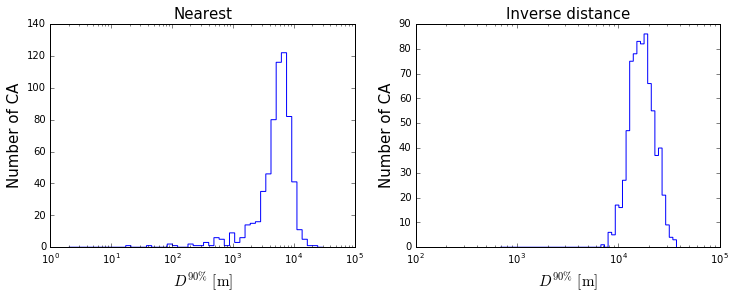

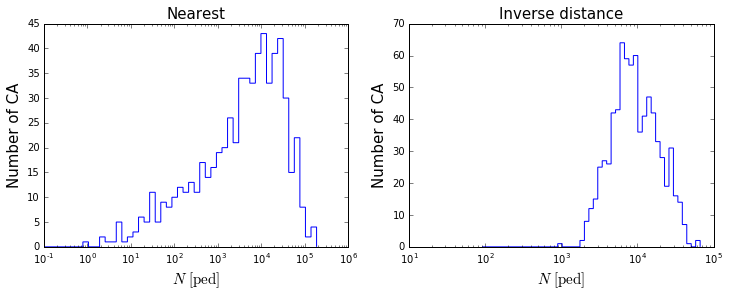

In [13]:
# Histogram of population and D90

import math
def lognorm_hist(dictionary,scenarios,label):
    plt.figure(figsize=(12,4))
    for i,scenario in enumerate(scenarios):
        data = dictionary[scenario]
        Nlog = np.log10(data)
        lmin = min(Nlog)-1
        lmax = max(Nlog)

        print label,scenario
        print 'mean',np.mean(data)
        print 'std',np.std(data)    
        print 'log of mean',np.log10(np.mean(data))
        print 'log of min',np.log10(np.min(data))
        print 'log of max',np.log10(np.max(data))    
            
        bins=np.logspace(lmin, lmax, 50)
        plt.subplot(121 + i)
        plt.title(scenario_name[scenario],fontsize=15)
        plt.hist(data,bins=bins,histtype='step')
        plt.xlabel('${0} \ \mathrm{{{1}}}$'.format(pl[label],unit[label]),fontsize=15)
        plt.ylabel('Number of CA',fontsize=15)
        plt.xscale('log')
    plt.savefig('pre2015/lognorm-hist-{0}.pdf'.format(label),bbox_inches='tight')

# 3B
lognorm_hist(D90,['k5','k5-idp'],'D90')
# 3C
lognorm_hist(N,['k5','k5-idp'],'N')

# FIG 4: Flow over time for a single catchment area

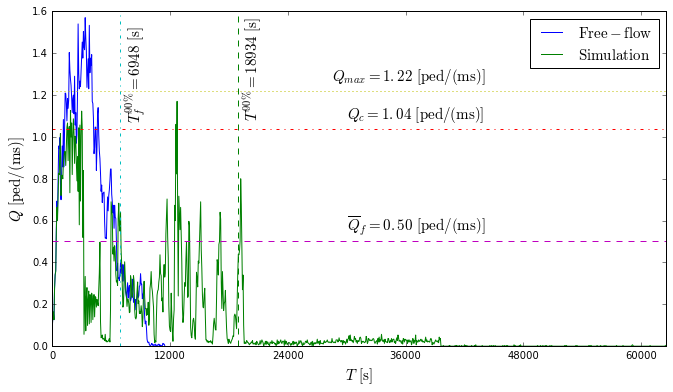

In [14]:
# Example of catchment area free flow and simulated flow

key = ('City of Bristol',sample[1])

plt.close('all')

fig = plt.figure(figsize=(11,6))

qf = np.array(Qf[scenario].loc[key])/60./W.loc[key]
q = np.array(Q[scenario].loc[key])/60./W.loc[key]
plt.plot(qf,label='$\mathrm{Free-flow}$')
plt.plot(q,label='$\mathrm{Simulation}$')

Qmax = 1.22
offset = 0.05

plt.axhline(Qmax,linestyle=':',color='y')
plt.text(475,1.220+offset,'$Q_{{max}} = {:0.2f} \ \mathrm{{ [ped/(ms)] }}$'.format(Qmax),fontsize=15)
plt.axhline(Qp[scenario].loc[key],linestyle='-.',color='r')
plt.text(500,1.039+offset,'$Q_c = {:0.2f} \ \mathrm{{ [ped/(ms)] }}$'.format(Qp[scenario].loc[key]),fontsize=15)
plt.axhline(Qmf[scenario].loc[key],linestyle='--',color='m')
plt.text(500,0.5+offset,'$\overline{{Q}}_{{f}} = {:0.2f} \ \mathrm{{ [ped/(ms)] }}$'.format(Qmf[scenario].loc[key]),fontsize=15)

plt.axvline(T90f[scenario].loc[key],linestyle='-.',color='c')
plt.text(120+offset*20,1.45,'$T^{{90\%}}_f = {:0.0f} \ \mathrm{{ [s] }}$'.format((T90f[scenario].loc[key]*60)),fontsize=15,rotation=90)
plt.axvline(T90[scenario].loc[key],linestyle='--',color='g')
plt.text(320+offset*20,1.5,'$T^{{90\%}} = {:0.0f} \ \mathrm{{ [s] }}$'.format((T90[scenario].loc[key]*60)),fontsize=15,rotation=90)

plt.xlim(0,len(q))

xticks = range(0,len(q),200)
xticklabs = np.array(xticks)*60
plt.xticks(xticks,xticklabs)

handles, labels = plt.gca().get_legend_handles_labels()
lgd = plt.legend(handles, labels, loc='upper right',fontsize=15)

plt.xlabel('$T \ \mathrm{ [s] }$',fontsize=15)
plt.ylabel('$Q \ \mathrm{ [ped/(ms)] }$',fontsize=15)

plt.savefig('pre2015/single-CA-T-Q.pdf',bbox_inches='tight')

# Process trajectories*

*Only runs if there is no cached trajectories

In [169]:
import os.path

for scenario in ['k5','k5-idp']:

    process = False
    for x in sample:
        fname = 'pre2015/{}-{}.mv.gz'.format(scenario,x)
        if not os.path.isfile(fname):
            process = True
    
    if process:
        s.init_scenario(scenario)
        s.load_events()

        sum_velocity = {k:{} for k in s.h.destins}
        sum_agent_count = {k:{} for k in s.h.destins}

        t90 = [e[-1][1] for e in s.events]

        max_vals = DF[scenario].loc['City of Bristol'][['dist2x','time2x']].groupby(level=[1]).max()

        for x,v in max_vals.iterrows():
            d2x,t2x = v
            sum_velocity[x] = np.zeros((int(d2x)+1,int(t2x)+1))
            sum_agent_count[x] = np.zeros((int(d2x)+1,int(t2x)+1))

        for event in s.events:
            destin, _ = event[-1]
            u, tu = event[0]
            for v, tv in event[1:]:
                distance = s.h.G[u][v]['distance']
                du = int(distance + s.h.route_length[destin][v])
                dv = int(s.h.route_length[destin][v])
                velocity = distance / (tv-tu) / 60
                # dist from v < dist from u
                for d,t in zip(np.linspace(du,dv,du-dv+1,dtype=int),np.linspace(tu,tv,du-dv+1,dtype=int)):
                    if t >= 0:
                        sum_velocity[destin][d,t] += velocity
                        sum_agent_count[destin][d,t] += 1
                u = v
                tu = tv

        for x in sample:
            mean_velocity = sum_velocity[x]/sum_agent_count[x]
            fname = 'pre2015/{}-{}.mv.gz'.format(scenario,x)
            with gzip.open(fname,'w') as f:
                pickle.dump(mean_velocity,f)

# Plot trajectories

INFO:core.abm:[k5:City of Bristol] Current scenario set to (With Interaction, No Intervention).
INFO:core.abm:[k5:City of Bristol] Event file contains record for 4% of 442455 agents


[k5:City of Bristol] Current scenario set to (With Interaction, No Intervention).
[k5:City of Bristol] Event file contains record for 4% of 442455 agents
k5 88 of 583 mins (15%), 993 of 2846 metres (35%)
k5 48154 1008.6946 891.44217


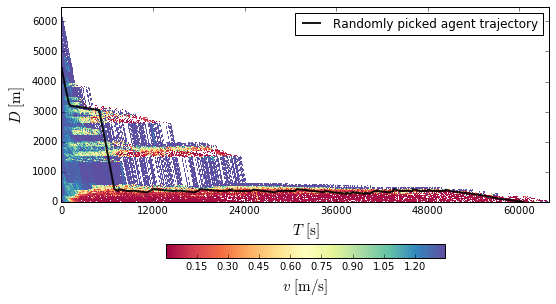

k5 21817 1188.3386 1126.47924


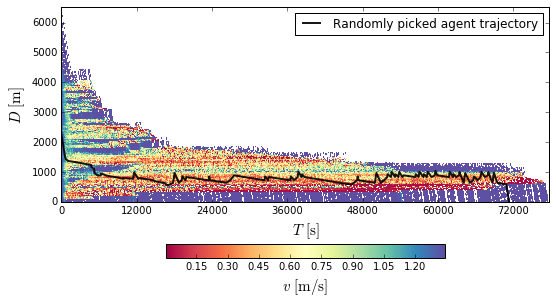

k5 9957 1088.2592 953.17762


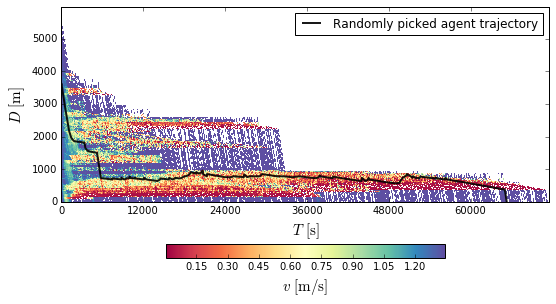

INFO:core.abm:[k5-idp:City of Bristol] Current scenario set to (With Interaction, No Intervention).
INFO:core.abm:[k5-idp:City of Bristol] Event file contains record for 4% of 442455 agents


[k5-idp:City of Bristol] Current scenario set to (With Interaction, No Intervention).
[k5-idp:City of Bristol] Event file contains record for 4% of 442455 agents
k5-idp 19 of 266 mins (7%), 461 of 6981 metres (7%)
k5-idp 48154 597.3786 303.82047


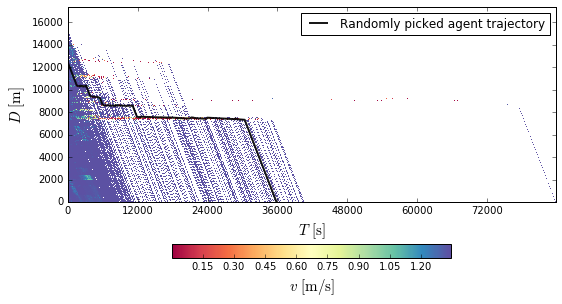

k5-idp 21817 557.6137 313.5533


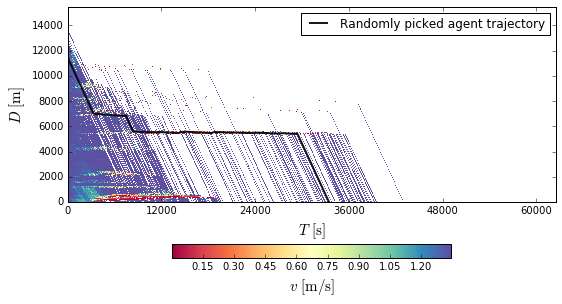

k5-idp 9957 380.0287 260.8464


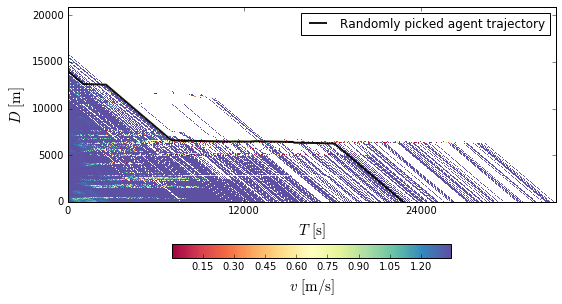

In [239]:
def do_sum_backflow_time(events):
    sum_backflow_time = 0
    sum_final_time = 0
    sum_backflow_dist = 0
    sum_final_dist = 0    
    for event in events:
        x = event[-1][0]
        dax,tax = zip(*[(s.h.route_length[x][n],t) for n,t in event])
        last_d,last_t = dax[0],tax[0]

        sum_final_dist += last_d
        
        for d,t in zip(dax[1:],tax[1:]):
            # If distance has increased since last time, add to backflow time
            if d > last_d:
                sum_backflow_time += t - last_t
                sum_backflow_dist += d - last_d
            last_d = d
            last_t = t

        sum_final_time += t

    num_agents = len(events)
    
    return '{:0.0f} of {:0.0f} mins ({:0.0f}%), {:0.0f} of {:0.0f} metres ({:0.0f}%)'.format(sum_backflow_time/num_agents,sum_final_time/num_agents,sum_backflow_time/sum_final_time*100,
            sum_backflow_dist/num_agents,sum_final_dist/num_agents,sum_backflow_dist/sum_final_dist*100)

def group_events_by_destination(events):
    events_dict = dict()
    for event in events:
        x = event[-1][0]
        if not events_dict.has_key(x):
            events_dict[x] = list()
        events_dict[x].append(event)
    return events_dict

output = []

# Produce figures
for scenario in ['k5','k5-idp']:
    s.init_scenario(scenario)
    s.load_events()
    
    print scenario, do_sum_backflow_time(s.events)
    
    # Group events by destination
    events = group_events_by_destination(s.events)
    # Destinations we want to display
    for x in sample:
        with gzip.open('pre2015/{}-{}.mv.gz'.format(scenario,x),'r') as f:
            mean_velocity = pickle.load(f)

        dD,dT = mean_velocity.shape
        aspect = float(dT)/dD*0.4

        threshold = np.percentile([event[-1][1] for event in events[x]],90)
        
        skip = 0
        event = None
        for this_event in events[x]:
            if this_event[-1][1] > threshold:
                event = this_event
                if skip > 2:
                    break
                else:
                    skip +=1

        print scenario, x, event[-1][1], threshold
            
        plt.figure(figsize=(10,5))
        plt.imshow(mean_velocity,interpolation='none',cmap='Spectral',aspect=aspect,origin='lower')
        plt.xlabel('$T \ \mathrm{[s]}$',fontsize=15)
        plt.ylabel('$D \ \mathrm{[m]}$',fontsize=15)
        plt.xlim(0,None)
        plt.ylim(0,None)
        max_dist,max_time = mean_velocity.shape
        xticks = range(0,max_time,200)
        xticklabs = np.array(xticks)*60
        plt.xticks(xticks,xticklabs)
        dax,tax = zip(*[(s.h.route_length[x][n],t) for n,t in event])
        plt.plot(tax,dax,label='Randomly picked agent trajectory',linewidth=2,c='black',alpha=0.9)
        cbar = plt.colorbar(orientation='horizontal',shrink=0.5)
        cbar.set_label('$v \ \mathrm{[m/s]}$',fontsize=15)
        plt.legend()
        plt.savefig('pre2015/mv-{}-{}.pdf'.format(scenario,x),bbox_inches='tight')
        plt.show()

In [227]:
print 'a\nb'

a
b


In [233]:
s.h.route_length[event[-1][0]][event[-1][0]]

0

# Aggregated flow across all catchment areas over time

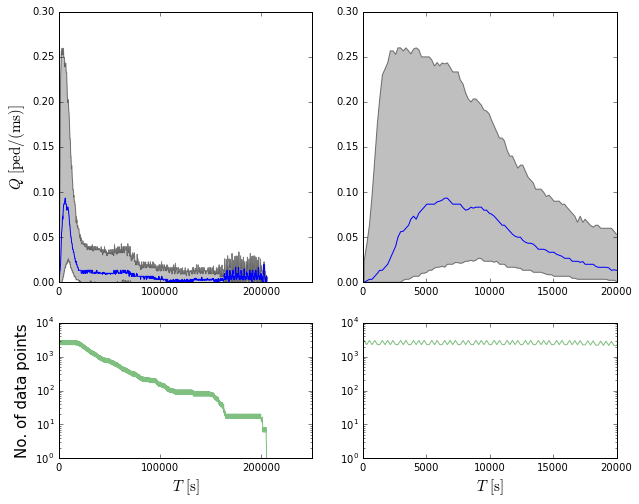

In [17]:
CI = 68

'''civ needs to be a value between 0-100'''

upper = 50 + CI/2
lower = 50 - CI/2

scenario = 'k5-idp'

# Looking at all cities here
# Flow vs time with 50%-CI/2, 50%, 50%+CI  marked
all_x=[]
all_y=[]

# Normalised flow vs normalised time with 50%-CI/2, 50%, 50%+CI/2  marked
all_norm_x=[]
all_norm_y=[]

for k,y in Q[scenario].iteritems():
    # Only proceed if there are agents present in this destination
    x = np.array(range(len(y)))
    y = np.array(y)/W.loc[k]/60.
    all_x.extend(x)
    all_y.extend(y)
    all_norm_x.extend(x/T90f[scenario].loc[k])
    all_norm_y.extend(y/Qp[scenario].loc[k])

all_x = np.array(all_x)*60.
all_y = np.array(all_y)
all_norm_x = np.array(all_norm_x)
all_norm_y = np.array(all_norm_y)

# Regular figures
nbins = {
            'k5':5000,
            'k5-idp':1000,
        }

H,xedges=np.histogram(all_x,bins=nbins[scenario])
digitized = np.digitize(all_x, xedges)
x_range = np.array(range(len(xedges)))+1
x_len = np.array([len(all_x[digitized == i]) for i in x_range])
x_mean = np.array([all_x[digitized == i].mean() for i in x_range])
y_lower = np.array([np.percentile(all_y[digitized == i],lower) for i in x_range])
y_median = np.array([np.percentile(all_y[digitized == i],50) for i in x_range])
y_upper = np.array([np.percentile(all_y[digitized == i],upper) for i in x_range])

from matplotlib import gridspec

myxticks = {
    'k5': [0,100000,200000,300000],
    'k5-idp': [0,100000,200000],
}

fig = plt.figure(figsize=(10,8))
gs = gridspec.GridSpec(2, 2,height_ratios=[2,1])
# LHS
ax0 = plt.subplot(gs[0])
ax0.plot(x_mean,y_median,label='$Q \ \mathrm{[ped/(ms)]}$')
ax0.fill_between(x_mean,y_upper,y_lower,facecolor='gray',alpha=0.5)
ax0.set_ylabel('$Q \ \mathrm{[ped/(ms)]}$',fontsize=15)
ax0.set_xticks(myxticks[scenario])
ax1 = plt.subplot(gs[2])
ax1.plot(x_mean,x_len,label='No. of data points',color='g',alpha=0.5)
ax1.set_xlabel('$T \ \mathrm{[s]}$',fontsize=15)
ax1.set_ylabel('No. of data points',fontsize=15)
ax1.set_yscale('log')
ax1.set_xticks(myxticks[scenario])
# RHS

xlim = {'k5':10000,'k5-idp':20000}

ax3 = plt.subplot(gs[1])
ax3.plot(x_mean,y_median)
ax3.fill_between(x_mean,y_upper,y_lower,facecolor='gray',alpha=0.5)
ax3.set_xlim(None,xlim[scenario])   
ax4 = plt.subplot(gs[3])
ax4.plot(x_mean,x_len,color='g',alpha=0.5)
ax4.set_xlabel('$T \ \mathrm{[s]}$',fontsize=15)
ax4.set_yscale('log',fontsize=15)
ax4.set_xlim(None,xlim[scenario])
ax4.axvline(1,c='r',linestyle='-.',label='$T/{0} = 1$'.format(pl['T90f']))    
plt.savefig('pre2015/{}-{}-all-T-Q.pdf'.format(CI,scenario),bbox_inches='tight')

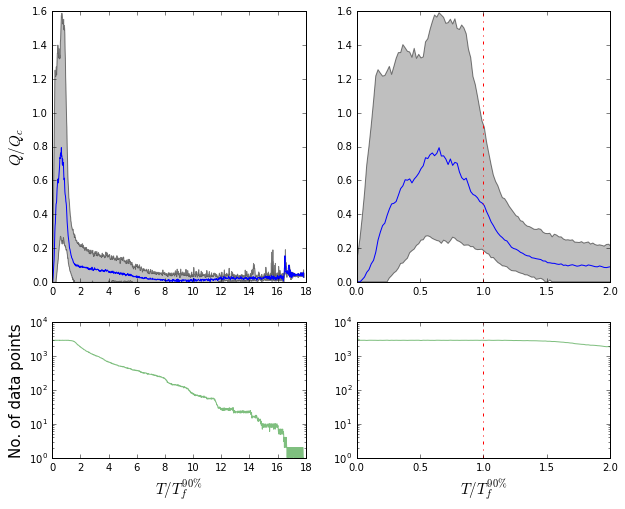

In [18]:

# Regular figures
nbins = {
            'k5':5000,
            'k5-idp':1000,
        }

# Normalised figures
H,xedges=np.histogram(all_norm_x,bins=nbins[scenario])
digitized = np.digitize(all_norm_x, xedges)
x_range = np.array(range(len(xedges)))+1
x_len = np.array([len(all_norm_x[digitized == i]) for i in x_range])
x_mean = np.array([all_norm_x[digitized == i].mean() for i in x_range])
y_lower = np.array([np.percentile(all_norm_y[digitized == i],lower) for i in x_range])
y_median = np.array([np.percentile(all_norm_y[digitized == i],50) for i in x_range])
y_upper = np.array([np.percentile(all_norm_y[digitized == i],upper) for i in x_range])    
#***
fig = plt.figure(figsize=(10,8))
gs = gridspec.GridSpec(2, 2, height_ratios=[2,1], width_ratios=[1,1])
# LHS
ax0 = plt.subplot(gs[0])
ax0.plot(x_mean,y_median)
ax0.fill_between(x_mean,y_upper,y_lower,facecolor='gray',alpha=0.5)
ax0.set_ylabel('$Q/{0}$'.format(pl['Qp']),fontsize=15)
ax2 = plt.subplot(gs[2])
ax2.plot(x_mean,x_len,label='No. of data points',color='g',alpha=0.5)
ax2.set_xlabel('$T/{0}$'.format(pl['T90f']),fontsize=15)
ax2.set_ylabel('No. of data points',fontsize=15)
ax2.set_yscale('log',fontsize=15)
# RHS
ax3 = plt.subplot(gs[1])
ax3.plot(x_mean,y_median)
ax3.fill_between(x_mean,y_upper,y_lower,facecolor='gray',alpha=0.5)
ax3.set_xlim(None,2)   
ax3.axvline(1,c='r',linestyle='-.',label='$\mathrm{T/T_f^{90\%} = 1}$')
ax4 = plt.subplot(gs[3])
ax4.plot(x_mean,x_len,color='g',alpha=0.5)
ax4.set_xlabel('$T/{0}$'.format(pl['T90f']),fontsize=15)
ax4.set_yscale('log',fontsize=15)
ax4.set_xlim(None,2)
ax4.axvline(1,c='r',linestyle='-.',label='$T/{0} = 1$'.format(pl['T90f']))    
plt.savefig('pre2015/{}-{}-all-norm-T-Q.pdf'.format(CI,scenario),bbox_inches='tight')


Could not normalise for N
Could not normalise for W
k5 theta = 0.803 gamma = 0.417 r^2 = 0.912
k6 theta = 0.772 gamma = 0.372 r^2 = 0.922
k7 theta = 0.802 gamma = 0.409 r^2 = 0.931
k5-idp theta = 0.848 gamma = 0.473 r^2 = 0.849
k6-idp theta = 0.874 gamma = 0.495 r^2 = 0.855
k7-idp theta = 0.867 gamma = 0.506 r^2 = 0.863


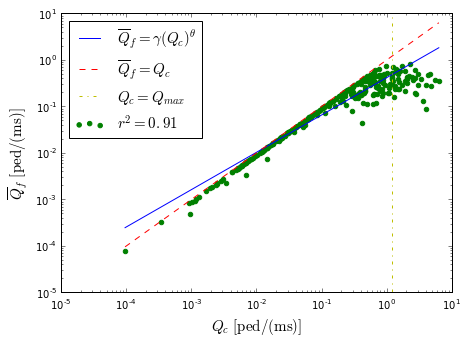

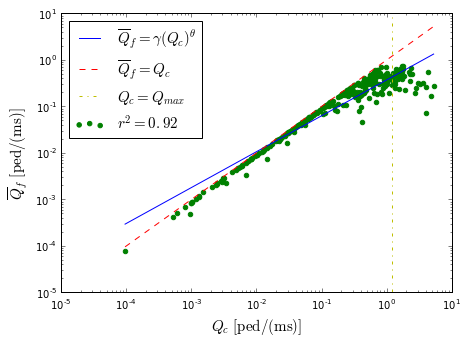

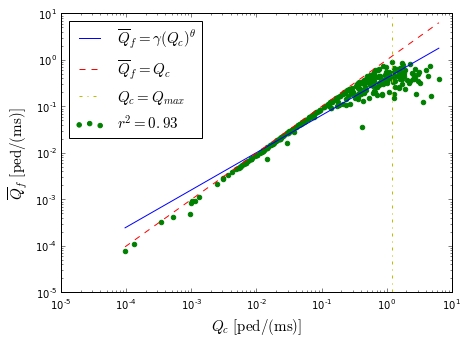

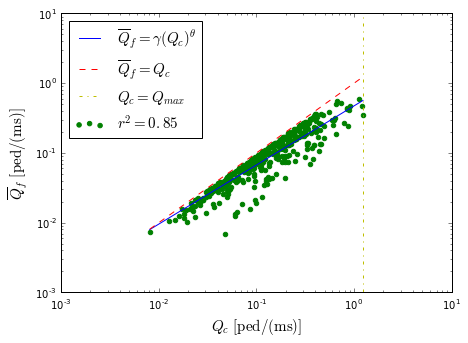

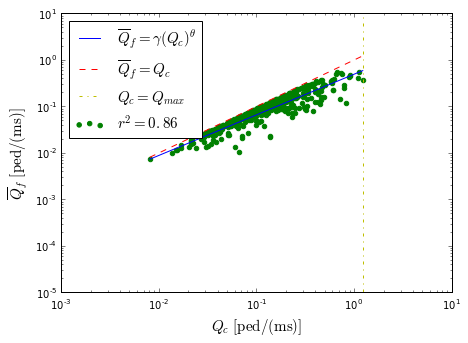

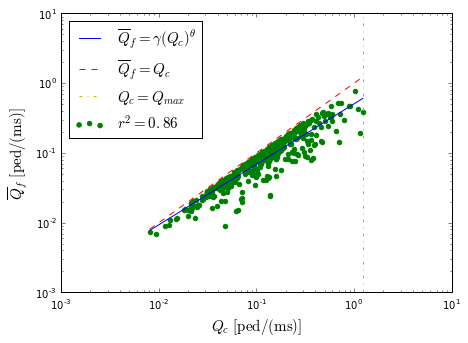

In [134]:
"""FIG 7A"""
# Qc vs Qmf
import random

normdict = {'D':'D90','T':'T90f','Q':'Qp'}

nl = {}
npl = {}

for l in pl.keys():
    try:
        # label to normalise with
        nw = normdict[l[0]]
        # matrix to normalise with
        nl[l] = '{0}/{1}'.format(l,nw)
        npl[l] = '{0}/{1}'.format(pl[l],pl[nw])
    except KeyError:
        nl[l] = l
        npl[l] = pl[l]
        print 'Could not normalise for',l

theta = {}
gamma = {}
r2 = {}

for scenario in scenarios:
    l1 = 'Qp'
    l2 = 'Qmf'

    f=shelve.open('pre2015/train-test-{}'.format(scenario))
    if not f.keys():
        noofCA = len(Qp[scenario])
        dataindex = range(noofCA)
        random.shuffle(dataindex)
        
        f['test'] = dataindex[:int(noofCA/2)]
        f['train'] = dataindex[int(noofCA/2):]
        print scenario, len(f['train']), len( f['test'])

    train = f['train']
    test = f['test']
    f.close()

    y = Qmf[scenario].astype(np.float64)
    X = Qp[scenario].astype(np.float64).reshape(-1,1)
    
    model = LinearRegression()
    model.fit(X=np.log(X[train]),y=np.log(y[train]))
    
    r2[scenario] = model.score(X=np.log(X[test]),y=np.log(y[test]))

    theta[scenario] = model.coef_[0]
    gamma[scenario] = np.exp(model.intercept_)

    # To fit y = Ax^B, take the log of both side gives log y = B log(x) + log(A).

    Xrange = np.linspace(X[test].min(),X[test].max(),100)
    
    Qmax = max(fd.q)

    plt.figure(figsize=(7,5))
    plt.scatter(X[test],y[test],color='g',label='$r^2 = {:0.2f}$'.format(r2[scenario]))
    plt.xscale('log')
    plt.yscale('log')
    plt.plot(Xrange,gamma[scenario]*Xrange**theta[scenario],'b-',label='${1} = \gamma ({0})^{{\\theta}}$'.format(pl[l1],pl[l2])) # A red solid line
    plt.plot(Xrange,Xrange,'r--',label='${1} = {0}$'.format(pl[l1],pl[l2]))
    plt.axvline(Qmax,c='y',linestyle='-.',label='$Q_c = Q_{max}$')
    plt.legend(loc='upper left',fontsize=15) # make a legend in the best location
    plt.xlabel('${0} \ \mathrm{{ {1} }}$'.format(pl[l1],unit[l1]),fontsize=15)
    plt.ylabel('${0} \ \mathrm{{ {1} }}$'.format(pl[l2],unit[l2]),fontsize=15) # labels again
    plt.savefig('pre2015/{}-{}-{}.pdf'.format(scenario,l1,l2),bbox_inches='tight')
    
for scenario in scenarios:
    print '{} theta = {:0.3f} gamma = {:0.3f} r^2 = {:0.3f}'.format(scenario,theta[scenario],gamma[scenario], r2[scenario])

k5 alpha = -1.353 beta = 0.919 r^2 = 0.902
k6 alpha = -1.334 beta = 0.919 r^2 = 0.860
k7 alpha = -1.277 beta = 0.916 r^2 = 0.892
k5-idp alpha = -1.441 beta = 0.989 r^2 = 0.762
k6-idp alpha = -1.397 beta = 0.986 r^2 = 0.788
k7-idp alpha = -1.385 beta = 0.961 r^2 = 0.780


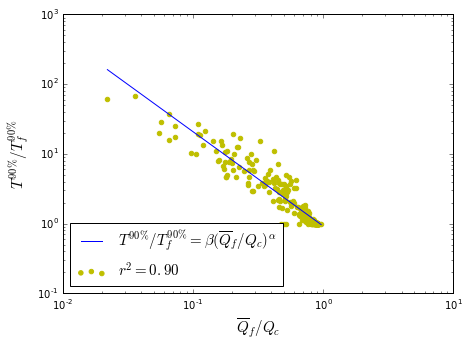

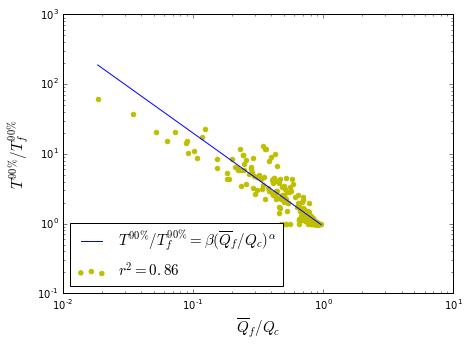

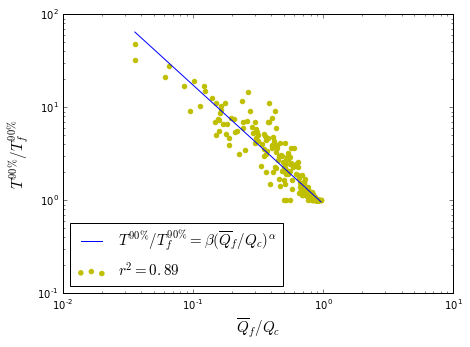

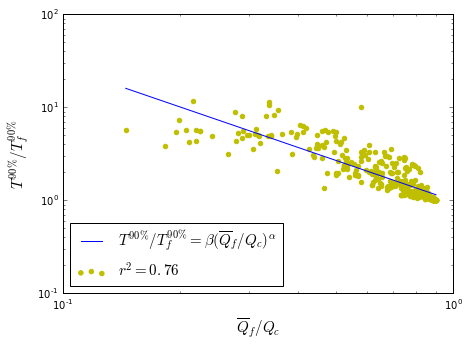

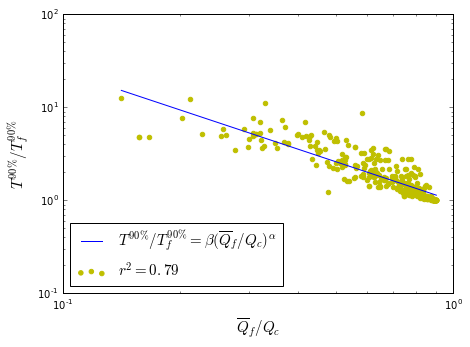

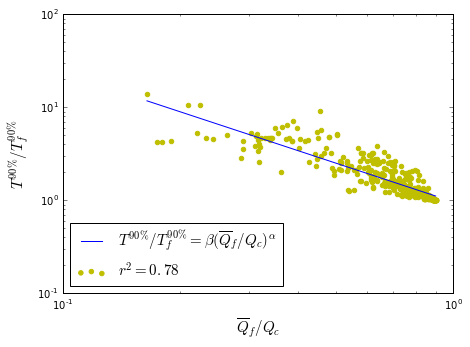

In [132]:
"""FIG 7B"""

alpha = {}
beta = {}
r2 = {}
for scenario in scenarios:
    # Tr vs Qr
    l1 = 'Qmf'
    l2 = 'T90'

    f=shelve.open('pre2015/train-test-{}'.format(scenario))
    train = f['train']
    test = f['test']
    f.close()

    y = Tr[scenario].astype(np.float64)
    X = Qr[scenario].astype(np.float64).reshape(-1,1)

    model = LinearRegression()
    model.fit(X=np.log(X[train]),y=np.log(y[train]))
    
    r2[scenario] = model.score(X=np.log(X[test]),y=np.log(y[test]))

    alpha[scenario] = model.coef_[0]
    beta[scenario] = np.exp(model.intercept_)

    # To fit y = Ax^B, take the log of both side gives log y = B log(x) + log(A).

    Xrange = np.linspace(X[test].min(),X[test].max(),100)

    plt.figure(figsize=(7,5))
    plt.scatter(X[test],y[test],color='y',label='$r^2 = {:0.2f}$'.format(r2[scenario]))
    plt.xscale('log')
    plt.yscale('log')
    plt.plot(Xrange,beta[scenario]*Xrange**alpha[scenario],'b-',label='${1} = \\beta ({0})^{{\\alpha}}$'.format(npl[l1],npl[l2])) # A red solid line
    plt.legend(loc='lower left',fontsize=15) # make a legend in the best location
    plt.xlabel('${0}$'.format(npl[l1]),fontsize=15)
    plt.ylabel('${0}$'.format(npl[l2]),fontsize=15) # labels again
    plt.savefig('pre2015/{}-{}-{}.pdf'.format(scenario,nl[l1].replace('/',':'),nl[l2].replace('/',':')),bbox_inches='tight')

for scenario in scenarios:
    print '{} alpha = {:0.3f} beta = {:0.3f} r^2 = {:0.3f}'.format(scenario, alpha[scenario], beta[scenario], r2[scenario])

# Determining phi, omega

In [135]:
phi = {}
omega = {}

for scenario in scenarios:
    # Calculate phi and omega
    omega[scenario] = beta[scenario]*gamma[scenario]**alpha[scenario]
    phi[scenario] = alpha[scenario]*(theta[scenario]-1)

    print '{} phi = {:0.3f} omega = {:0.3f}'.format(scenario, phi[scenario], omega[scenario])
    
for scenario in scenarios:
    top = 'k5-idp' if len(scenario) > 2 else 'k5' 
    if top != scenario:
        print '{}/{} (phi = {:0.0f}%, omega = {:0.0f}%)'.format(top, scenario, phi[top]/phi[scenario]*100-100, omega[top]/omega[scenario]*100-100)

k5 phi = 0.267 omega = 3.004
k6 phi = 0.305 omega = 3.431
k7 phi = 0.253 omega = 2.871
k5-idp phi = 0.220 omega = 2.906
k6-idp phi = 0.176 omega = 2.637
k7-idp phi = 0.184 omega = 2.468
k5/k6 (phi = -12%, omega = -12%)
k5/k7 (phi = 5%, omega = 5%)
k5-idp/k6-idp (phi = 24%, omega = 10%)
k5-idp/k7-idp (phi = 20%, omega = 18%)


# Determining zeta, eta

k7 1.06606695088 0.735597502568
k6 1.05004200343 0.785363215501
k5 1.08216257239 0.676631303952
k7-idp 0.97214505286 1.17759404333
k6-idp 0.968871326098 1.2038484514
k5-idp 0.846184190645 2.49897773061


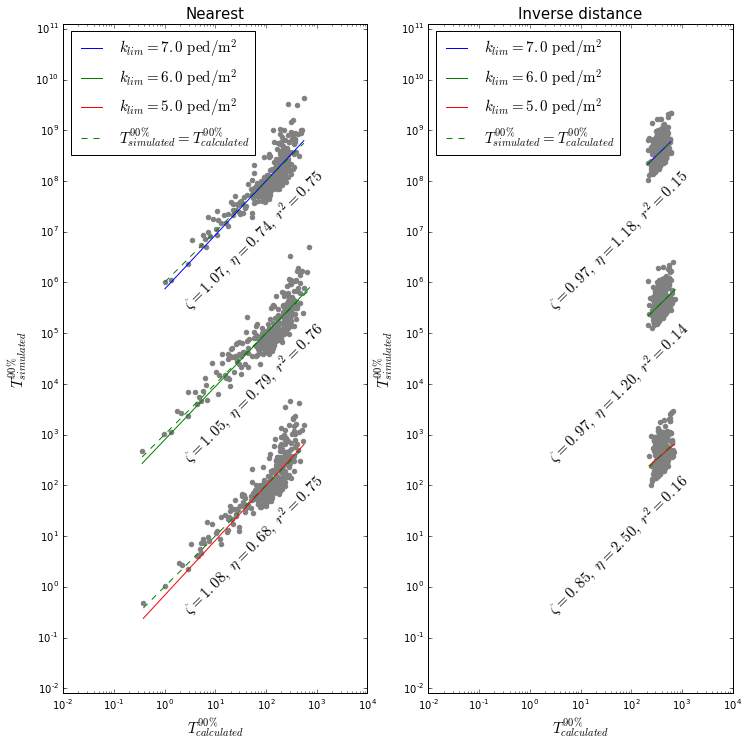

In [137]:
"""FIG 8"""

zeta = {}
eta = {}

r2 = {}
T90c = {}

l1 = 'T90'

plt.figure(figsize=(12,12))
for i,scenario in enumerate(['k7','k6','k5','k7-idp','k6-idp','k5-idp']):
    f=shelve.open('pre2015/train-test-{}'.format(scenario))
    train = f['train']
    test = f['test']
    f.close()

    T90c[scenario] = omega[scenario]*T90f[scenario]*Qp[scenario]**phi[scenario]

    y = T90[scenario].astype(np.float64)
    X = T90c[scenario].astype(np.float64).reshape(-1,1)
    
    model = LinearRegression()
    model.fit(X=np.log(X[train]),y=np.log(y[train]))
    
    r2[scenario] = model.score(X=np.log(X[test]),y=np.log(y[test]))

    zeta[scenario] = model.coef_[0]
    eta[scenario] = np.exp(model.intercept_)

    print scenario, zeta[scenario], eta[scenario]
    
    # To fit y = Ax^B, take the log of both side gives log y = B log(x) + log(A).

    Xrange = np.linspace(X[test].min(),X[test].max(),100)
    yoffset = np.array(10**(3*(2-i%3)))
    
    plt.subplot(121+i/3)
    
    plt.scatter(X[test],yoffset*y[test],color='gray',label='')
    plt.plot(Xrange,yoffset*eta[scenario]*Xrange**zeta[scenario],'-',label='$k_{{lim}} = {:0.1f} \ \mathrm{{ped/m^2}}$'.format(abm.settings[scenario]['k_lim'])) # A red solid line
    plt.text(2,yoffset*100,'$\zeta = {:0.2f},\ \eta = {:0.2f},\ r^2 = {:0.2f}$'.format(zeta[scenario],eta[scenario],r2[scenario]),rotation=45,fontsize=15)
    if i%3 == 2:
        plt.plot(Xrange,yoffset*Xrange,'g--',label='${0}_{{simulated}} = {0}_{{calculated}}$'.format(pl[l1])) # Diagonal
    else:
        plt.plot(Xrange,yoffset*Xrange,'g--') # Diagonal

    plt.title(scenario_name[scenario],fontsize=15)
    plt.xscale('log')
    plt.yscale('log')
    plt.axis('equal')
    plt.ylim(10**-3,10**12)
    plt.xlim(10**-2,10**4)
    plt.legend(loc='upper left',fontsize=15)
    plt.xlabel('${0}_{{calculated}}$'.format(pl[l1]),fontsize=15)
    plt.ylabel('${0}_{{simulated}}$'.format(pl[l1]),fontsize=15) # labels again
plt.savefig('pre2015/T90-T90.pdf',bbox_inches='tight')

# Output coefficients and compute delta

In [85]:
# Print phi, omega, zeta, eta table
k_lim = {k:v['k_lim'] for k,v in abm.settings.iteritems()}

for obselete in ['ff','ff-idp']:
    if k_lim.has_key(obselete):
        del k_lim[obselete]

coefftab =  pandas.DataFrame({'allocation':scenario_name,'k_lim':k_lim,'phi':phi,'omega':omega,'zeta':zeta,'eta':eta},columns=['allocation','k_lim','phi','omega','zeta','eta'])
coefftab.set_index(['allocation','k_lim'],inplace=True)
coefftab.sort_index(ascending=[0,1],inplace=True)
coefftab.round(3).to_latex('pre2015/coefftab.tex')
print coefftab.round(3)

                          phi  omega   zeta    eta
allocation       k_lim                            
Nearest          5      0.267  3.004  1.082  0.677
                 6      0.305  3.431  1.050  0.785
                 7      0.253  2.871  1.066  0.736
Inverse distance 5      0.220  2.906  0.846  2.499
                 6      0.176  2.637  0.969  1.204
                 7      0.184  2.468  0.972  1.178


# Load preprocessed metrics

In [86]:
import json

def load_json(metric,place,destin):
    print metric
    folder = folder_structure.format(sim, metric, place)
    print folder
    fname = file_structure.format(folder, destin)
    with gzip.open(fname, 'r') as infile:
        intermediate = json.load(infile)
        # Convert key to number or tuple before returning
        if metric == 'summary':
            return intermediate
        else:
            return {eval(key):value for key,value in intermediate.iteritems()}

folder_structure = 'metrics/{}/{}/{}'
file_structure = '{}/{}.json.gz'

scenario = 'k5'
lj = {}
for p,x in T90[scenario].index:
    v = load_json('summary',p,x)
    lj[(p,x)] = v
M = pandas.DataFrame(lj).applymap(lambda x: np.float(x)).T.loc[T90[scenario].index]
keys = M.columns

del M['min_sdsp']
del M['min_tdsp']
del M['num_attractcom']
del M['num_weakconcom']

summary
metrics/bristol25/summary/Aberdeen City
summary
metrics/bristol25/summary/Aberdeen City
summary
metrics/bristol25/summary/Aberdeen City
summary
metrics/bristol25/summary/Aberdeen City
summary
metrics/bristol25/summary/Aberdeen City
summary
metrics/bristol25/summary/Aberdeen City
summary
metrics/bristol25/summary/Amber Valley
summary
metrics/bristol25/summary/Amber Valley
summary
metrics/bristol25/summary/Amber Valley
summary
metrics/bristol25/summary/Amber Valley
summary
metrics/bristol25/summary/Amber Valley
summary
metrics/bristol25/summary/Amber Valley
summary
metrics/bristol25/summary/Amber Valley
summary
metrics/bristol25/summary/Amber Valley
summary
metrics/bristol25/summary/Amber Valley
summary
metrics/bristol25/summary/Amber Valley
summary
metrics/bristol25/summary/Amber Valley
summary
metrics/bristol25/summary/Amber Valley
summary
metrics/bristol25/summary/Amber Valley
summary
metrics/bristol25/summary/Amber Valley
summary
metrics/bristol25/summary/Amber Valley
summary

# dT90 and dT90norm Histograms

dT (629,)
dTnorm (629,)


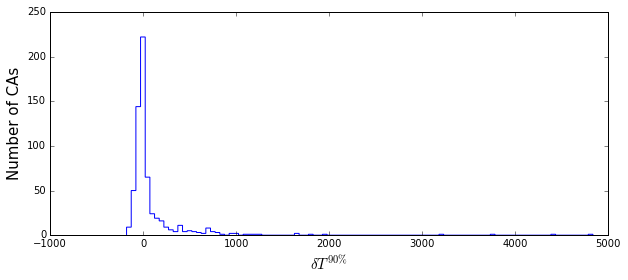

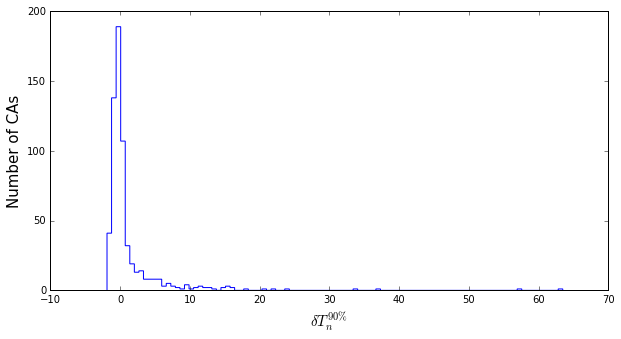

In [89]:
dT90 = {}
for scenario in scenarios:
    dT90[scenario] = T90[scenario] - T90c[scenario]

scenario = 'k5'    

M['dT'] = (dT90[scenario]).apply(lambda x: np.float(x))
M['dTnorm'] = (dT90[scenario]/T90f[scenario]).apply(lambda x: np.float(x))

print 'dT',M['dT'].shape
print 'dTnorm',M['dTnorm'].shape

"""dT90 norm histogram"""
plt.figure(figsize=(10,4))
# plt.hist(M['dTnorm'],bins=100,cumulative=True,histtype='step',normed=False)
plt.hist(M['dT'],bins=100,cumulative=False,histtype='step',normed=False)
plt.ylabel('Number of CAs',fontsize=15)
plt.xlabel('$\delta T^{90\%}$',fontsize=15)
plt.savefig('pre2015/hist-dT90.pdf'.format(scenario),bbox_inches='tight')

"""dT90 norm histogram"""
plt.figure(figsize=(10,5))
# plt.hist(M['dTnorm'],bins=100,cumulative=True,histtype='step',normed=False)
plt.hist(M['dTnorm'],bins=100,cumulative=False,histtype='step',normed=False)
plt.ylabel('Number of CAs',fontsize=15)
plt.xlabel('$\delta T^{90\%}_n$',fontsize=15)
plt.savefig('pre2015/hist-dT90-norm.pdf'.format(scenario),bbox_inches='tight')

# Topological metrics output to LaTeX tables

In [77]:
"""Topological metrics output to LaTeX tables"""

corrnorm = pandas.DataFrame()
corrnorm['pearson'] = M.corr('pearson')['dTnorm'].loc[keys]
corrnorm['spearman'] = M.corr('spearman')['dTnorm'].loc[keys]
corrnorm.to_csv('pre2015/corr.csv')

all_keys = list(corrnorm.index)

keys = [   
        'deg_cen',
        'in_deg_cen',
        'out_deg_cen',
        'bet_cen',
        'bet_cen_exit',
        'load_cen_exit',
        'eivec_cen_exit',
        'close_cen_exit',
        'sq_clust'
        ]

def components(key):
    return [
            'mean_{}'.format(key),
            'mean_{}_mean_sdsp'.format(key),
            'mean_{}_10pc_sdsp'.format(key),
            'mean_{}_50pc_sdsp'.format(key),
            'mean_{}_90pc_sdsp'.format(key),
            'mean_{}_2000m'.format(key),
            'mean_{}_1000m'.format(key),
            'mean_{}_500m'.format(key),
            'mean_{}_250m'.format(key),
            'mean_{}_mean_tdsp'.format(key),
            'mean_{}_10pc_tdsp'.format(key),
            'mean_{}_50pc_tdsp'.format(key),
            'mean_{}_90pc_tdsp'.format(key),
            'mean_{}_8_tdsp'.format(key),
            'mean_{}_4_tdsp'.format(key),
            'mean_{}_2_tdsp'.format(key),
            'mean_{}_1_tdsp'.format(key)
        ]

labels = [
    'All',
    'Mean Spatial Distance',
    '10% Spatial Distance',
    '50% Spatial Distance',
    '90% Spatial Distance',
    '2000 metres',
    '1000 metres',
    '500 metres',
    '250 metres',
    'Mean Topological Distance',
    '10% Topological Distance',
    '50% Topological Distance',
    '90% Topological Distance',
    '8 Topological Distance',
    '4 Topological Distance',
    '2 Topological Distance',
    '1 Topological Distance'
]

remaining = all_keys[:]
v = {}
for k in keys:
    this = components(k)
    v[k] = corrnorm.loc[this]
    v[k].index = labels
    for t in this:
        remaining.remove(t)

# Eigenvector and closeness are not for exits
tabular = pandas.concat(v).T.stack().unstack(level=0)

tabular[['in_deg_cen','out_deg_cen','deg_cen']].round(3).to_latex('pre2015/deg_cen.tex')
tabular[['bet_cen','bet_cen_exit']].round(3).to_latex('pre2015/bet_cen.tex')
tabular[['eivec_cen_exit','close_cen_exit','sq_clust']].round(3).to_latex('pre2015/others.tex')

keys_ns = [
    '{}_mean_sdsp',
    '{}_10pc_sdsp',
    '{}_50pc_sdsp',
    '{}_90pc_sdsp',
    '{}_2000m',
    '{}_1000m',
    '{}_500m',
    '{}_250m',
    '{}_mean_tdsp',
    '{}_10pc_tdsp',
    '{}_50pc_tdsp',
    '{}_90pc_tdsp',
    '{}_8_tdsp',
    '{}_4_tdsp',
    '{}_2_tdsp',
    '{}_1_tdsp',
    '{}_0_in_deg',
    '{}_1_in_deg',
    '{}_2_in_deg',
    '{}_3+_in_deg',
    '{}_0_out_deg',
    '{}_1_out_deg',
    '{}_2_out_deg',
    '{}_3+_out_deg',
]    

labels_ns = [
    'Mean Spatial Distance',
    '10% Spatial Distance',
    '50% Spatial Distance',
    '90% Spatial Distance',
    '2000 metres',
    '1000 metres',
    '500 metres',
    '250 metres',
    'Mean Topological Distance',
    '10% Topological Distance',
    '50% Topological Distance',
    '90% Topological Distance',
    '8 Topological Distance',
    '4 Topological Distance',
    '2 Topological Distance',
    '1 Topological Distance',
    '0 In-Degree',
    '1 In-Degree',
    '2 In-Degree',
    '3+ In-Degree',
    '0 Out-Degree',
    '1 Out-Degree',
    '2 Out-Degree',
    '3+ Out-Degree',
]    

ns = {}
for key in ['frac_nodes','num_nodes']:
    this = [k.format(key) for k in keys_ns]
    ns[key] = corrnorm.loc[this]
    ns[key].index = labels_ns
    for t in this:
        remaining.remove(t)

tabular_ns = pandas.concat(ns).T.stack().unstack(level=0)
tabular_ns.round(3).to_latex('pre2015/nodestats.tex')

keys_sp = [
    'mean_{}sp',
    '10pc_{}sp',
    '50pc_{}sp',
    '90pc_{}sp',
    'max_{}sp',
]

labels_sp = [
    'Mean',
    '10%',
    '50%',
    '90%',
    'Maximum',
]

sp = {}
for key in ['sd','td']:
    this = [k.format(key) for k in keys_sp]
    sp[key] = corrnorm.loc[this]
    sp[key].index = labels_sp
    for t in this:
        remaining.remove(t)

tabular_sp = pandas.concat(sp).T.stack().unstack(level=0)
tabular_sp.round(3).to_latex('pre2015/shortestpath.tex')

labels_final = [
    'Number of Nodes',
    'Number of Edges',
    'Mean Edge Width',
    'Mean Edge Length',
    'Mean Edge Area',
    'Total Edge Area',
    'Total Edge Length',
    'Mean Degree',
    'Graph Density',
    'Graph Transitivity',
    'Strongly Connected Components',
    'Mean Edge Betweenness Centrality',
    'Mean Edge Betweenness Centrality for Exit',    
]

keys_final = [
    u'num_nodes',
    u'num_edges',
    u'mean_edge_width',
    u'mean_edge_length',
    u'mean_edge_area',
    u'sum_edge_area',
    u'sum_edge_length',
    u'mean_degree',
    u'density',
    u'transitivity',
    u'num_strgconcom',
    u'mean_edge_bet_cen',
    u'mean_edge_bet_cen_exit',
]

tabular_final = corrnorm.loc[keys_final]
tabular_final.index = labels_final
tabular_final.round(3).to_latex('pre2015/remaining.tex')

# 'edge_betweenness_centrality',
# 'edge_betweenness_centrality_exit',

showing = {
    'in_degree_centrality':'In-degree centrality',
    'out_degree_centrality':'Out-degree centrality',
    'degree_centrality':'Degree centrality',
    'betweenness_centrality':'Betweenness centrality',
    'betweenness_centrality_exit':'Exit betweenness centrality',
    'eigenvector_centrality':'Eigenvector centrality',
    'closeness_centrality':'Closeness centrality',
    'square_clustering':'Square clustering',
    'spatial_distance':'Spatial distance from exit (metres)',
    'topological_distance':'Topological distance from exit (node hops)'
    }

# Visualising topological metrics for City of Bristol

betweenness_centrality_exit
metrics/bristol25/betweenness_centrality_exit/City of Bristol
betweenness_centrality_exit
metrics/bristol25/betweenness_centrality_exit/City of Bristol
betweenness_centrality_exit
metrics/bristol25/betweenness_centrality_exit/City of Bristol
closeness_centrality
metrics/bristol25/closeness_centrality/City of Bristol
closeness_centrality
metrics/bristol25/closeness_centrality/City of Bristol
closeness_centrality
metrics/bristol25/closeness_centrality/City of Bristol
in_degree_centrality
metrics/bristol25/in_degree_centrality/City of Bristol
in_degree_centrality
metrics/bristol25/in_degree_centrality/City of Bristol
in_degree_centrality
metrics/bristol25/in_degree_centrality/City of Bristol
eigenvector_centrality
metrics/bristol25/eigenvector_centrality/City of Bristol
eigenvector_centrality
metrics/bristol25/eigenvector_centrality/City of Bristol
eigenvector_centrality
metrics/bristol25/eigenvector_centrality/City of Bristol
out_degree_centrality
metrics/bris

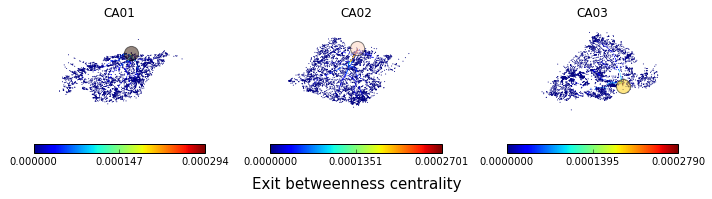

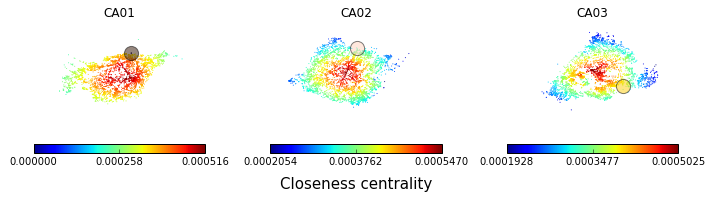

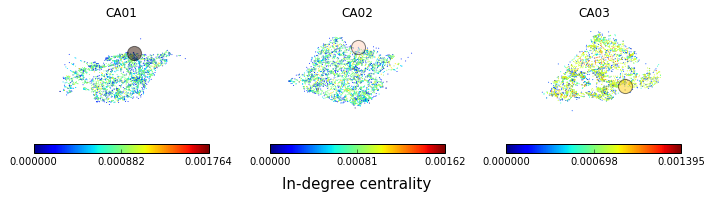

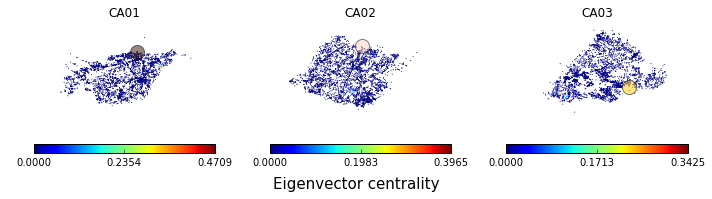

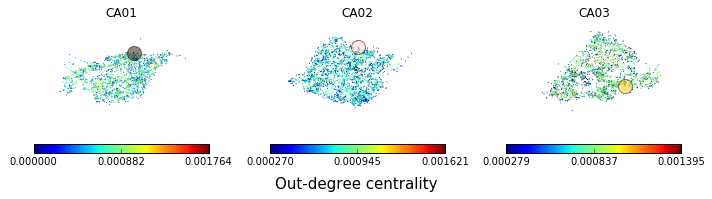

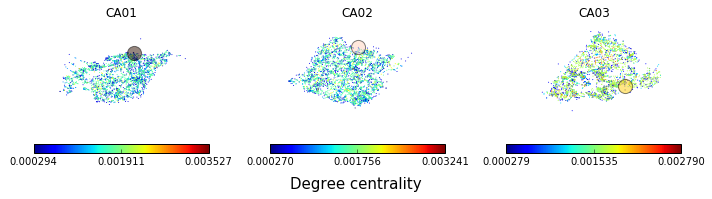

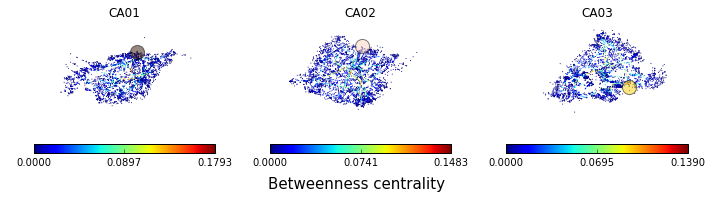

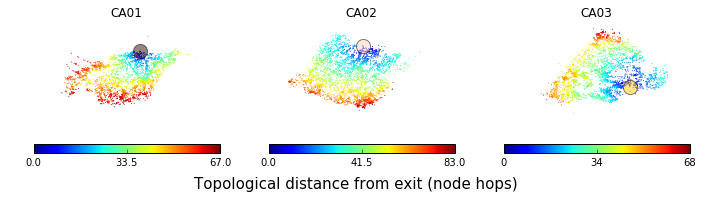

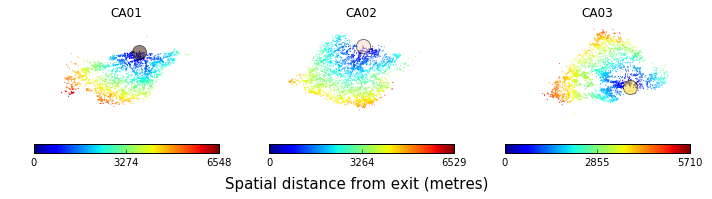

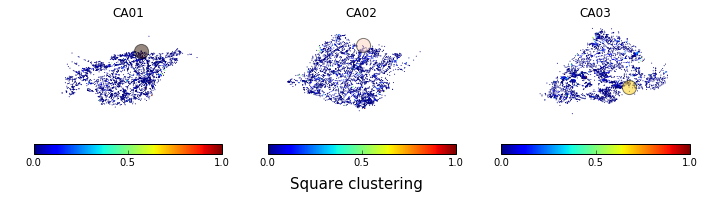

In [35]:
plt.close('all')
for show,label in showing.iteritems():
    plt.figure(figsize=(10,2.5))
    for i,x in enumerate(sample):
        ax = plt.subplot(131+i,frameon=False)
        bc = load_json(show,s.place,x)
        values = np.array(bc.values(),dtype=float)
        nxnodes = nx.draw_networkx_nodes(s.h.G,pos=nx.get_node_attributes(s.h.G,'pos'),nodelist=bc.keys(),node_color=values,linewidths=0,node_size=1)
        cbar = plt.colorbar(nxnodes,ticks=[values.min(),(values.min()+values.max())/2,values.max()],orientation='horizontal')
        plt.scatter(*pos[x],s=200,c=destin_color[x],alpha=0.5,marker='o',zorder=100)
        plt.title(attr[x]['label'])
        # plt.xlabel('Longitude',fontsize=15)
        # plt.ylabel('Latitude',fontsize=15)
        ax.axis('off')
        plt.axis('equal')
    plt.tight_layout()
    plt.suptitle(label,fontsize=15,y=0)
    plt.savefig('pre2015/metric-sample-bristol-{}.pdf'.format(show),bbox_inches='tight')

# T90 prediction before and after considering node and edges

train 315
test 314
expecting eta = 1.082, zeta = 0.677
eta = 1.082
zeta = 0.677
eta_c = 0.938, eta_n = 1.372, eta_e = -1.178
zeta = 1.029
r^2 before 0.752 after 0.780
r^2 after/before = 4%


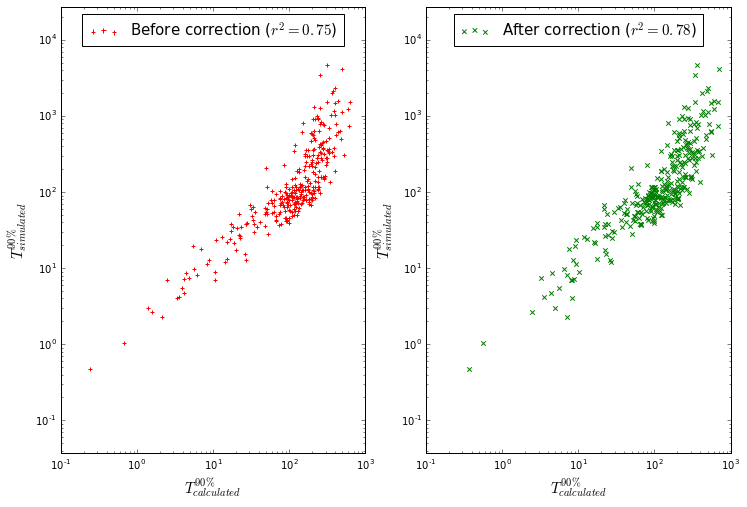

In [166]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()

scenario = 'k5'

f=shelve.open('pre2015/train-test-{}'.format(scenario))
train = f['train']
test = f['test']
print 'train',len(train)
print 'test',len(test)


ll = 'T90'

y = T90[scenario].astype(np.float64)
X = T90c[scenario].astype(np.float64).reshape(-1,1)

model_before = LinearRegression()
model_before.fit(X=np.log(X[train]),y=np.log(y[train]))

r2_before = model_before.score(X=np.log(X[test]),y=np.log(y[test]))

print 'expecting eta = {:0.3f}, zeta = {:0.3f}'.format(zeta[scenario], eta[scenario])

print 'eta = {:0.3f}'.format(*model_before.coef_)
print 'zeta = {:0.3f}'.format(np.exp(model_before.intercept_))

plt.figure(figsize=(12,8))

ypred_before = np.exp(model_before.predict(np.log(X[test])))

model_after = LinearRegression()

X = np.array(zip(T90c[scenario],M['num_nodes'],M['num_edges']),dtype=np.float64)

model_after.fit(X=np.log(X[train]), y=np.log(y[train]))
ypred_after = np.exp(model_after.predict(X=np.log(X[test])))

r2_after = model_after.score(np.log(X[test]),np.log(y[test]))

print 'eta_c = {:0.3f}, eta_n = {:0.3f}, eta_e = {:0.3f}'.format(*model_after.coef_)
print 'zeta = {:0.3f}'.format(np.exp(model_after.intercept_))

print 'r^2 before {:0.3f} after {:0.3f}'.format(r2_before, r2_after)
print 'r^2 after/before = {:0.0f}%'.format(r2_after/r2_before*100-100)

# Before
plt.subplot(121)
plt.scatter(ypred_before,y[test], marker='+', c='r', label = 'Before correction ($r^2 ={:0.2f}$)'.format(r2_before))

plt.xscale('log')
plt.yscale('log')
plt.axis('equal')
plt.legend(loc='upper center',fontsize=15)
plt.xlabel('${0}_{{calculated}}$'.format(pl[l1]),fontsize=15)
plt.ylabel('${0}_{{simulated}}$'.format(pl[l1]),fontsize=15) # labels again

# After

plt.subplot(122)
plt.scatter(ypred_after,y[test], marker='x', c='g', label = 'After correction ($r^2 ={:0.2f}$)'.format(r2_after))

plt.xscale('log')
plt.yscale('log')
plt.axis('equal')
plt.legend(loc='upper center',fontsize=15)
plt.xlabel('${0}_{{calculated}}$'.format(pl[l1]),fontsize=15)
plt.ylabel('${0}_{{simulated}}$'.format(pl[l1]),fontsize=15) # labels again
plt.savefig('pre2015/before-after-correction-T90-T90-{}.pdf'.format(scenario),bbox_inches='tight')